In [1]:
import pandas as pd
import numpy as np
import math
import pylab
import statsmodels.api as sm
import pandas_datareader
from statsmodels.regression.rolling import RollingOLS
from tabulate import tabulate
from pandas_datareader import data
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as si
import seaborn as sns
import sympy as sy
from sympy.stats import Normal, cdf
import urllib.request
import zipfile

Problem (1): ETF Factor Modeling--------------------------------------------------------------------------------------------------------------------------------------ETF Factor Modeling

part A---------------------------------------------------part A---------------------------------------------------part A---------------------------------------------------part A

In [2]:
#Import data
start_date = '2010-01-01'
end_date = '2020-12-31'
lst_tickers = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
def collect_data(lst_tickers, start_date, end_date):
    lst_1 = []
    lst_2 = []
    
    df = data.get_data_yahoo(lst_tickers[0], start = start_date, end = end_date)
    df = df[["Adj Close"]]
    df = df.dropna()
    index = df.index
    df.rename(columns = {"Adj Close" : lst_tickers[0]}, inplace=True)
    
    for j in range(1, len(lst_tickers)):
        lst_dataFrames = data.get_data_yahoo(lst_tickers[j], start = start_date, end = end_date)
        lst_dataFrames = lst_dataFrames.dropna()
        index_j = lst_dataFrames.index
        lst_dataFrames.rename(columns = {"Adj Close" : lst_tickers[j]}, inplace=True)
        df = pd.concat([df, lst_dataFrames], axis =1)
    return df

In [3]:
master_df = collect_data(lst_tickers, start_date, end_date)
master_df = master_df.drop(columns=['High', 'Low', 'Open', 'Close', 'Volume'])
#master_df

In [4]:
ff_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_daily_CSV.zip"
urllib.request.urlretrieve(ff_url,'fama_french.zip')
zip_file = zipfile.ZipFile('fama_french.zip', 'r')
zip_file.extractall()
zip_file.close()
famafrench = pd.read_csv('F-F_Research_Data_Factors_daily.csv',skiprows = 3, nrows=25041, index_col = 0)
famafrench.index = pd.to_datetime(famafrench.index, format = '%Y%m%d')
# adds a true market return column
Mkt = famafrench['Mkt-RF'] + famafrench['RF']
famafrench['Mkt'] = Mkt
famafrench = famafrench[famafrench.index > start_date]
famafrench = famafrench[famafrench.index <= end_date]
famafrench = famafrench.apply(lambda x: x/100)

In [5]:
#merge the fama-french and sectors data frams into one whole data frame

In [6]:
master_df = master_df.pct_change()
master_df.replace([np.inf, -np.inf], np.nan, inplace=True)
master_df = master_df.dropna()
master_df = pd.concat([master_df, famafrench], axis =1)
master_df = master_df.dropna()
#master_df
#print(tabulate(master_df, headers=['Date','SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY','Mkt-RF','SMB','HML','RF','Mkt'], tablefmt="latex"))

part B---------------------------------------------------part B---------------------------------------------------part B---------------------------------------------------part B

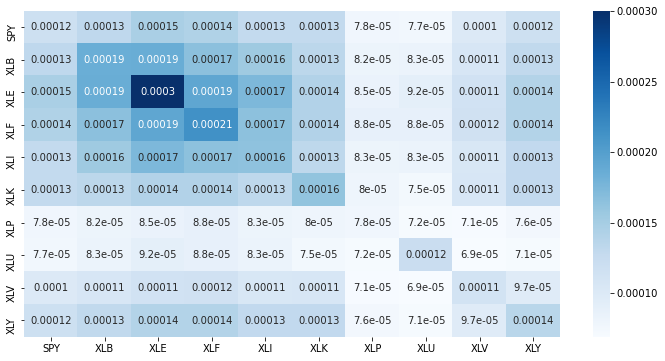

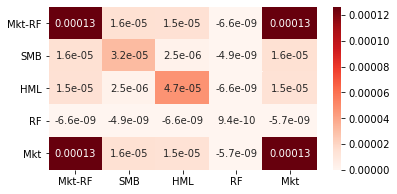

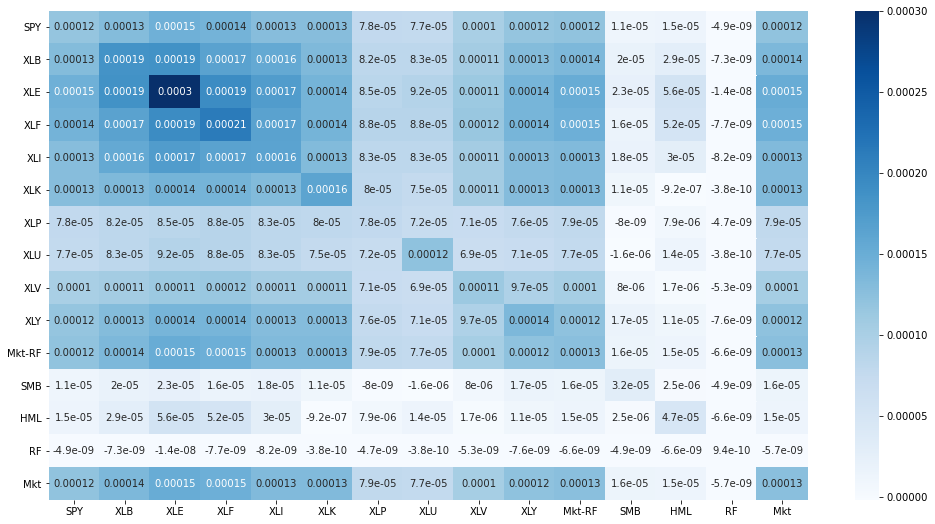

In [7]:
plt.figure(figsize = (12,6))
sns.heatmap(master_df[['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']].cov(), cmap="Blues", annot=True)
plt.show()

plt.figure(figsize = (6,3))
sns.heatmap(master_df[['Mkt-RF','SMB','HML','RF','Mkt']].cov(), cmap="Reds", annot=True)
plt.show()

plt.figure(figsize = (17,9))
sns.heatmap(master_df.cov(), cmap="Blues", annot=True)
plt.show()

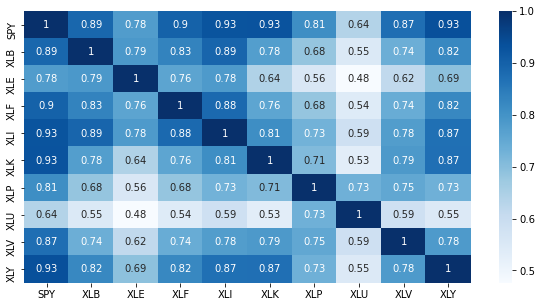

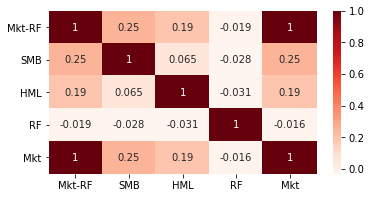

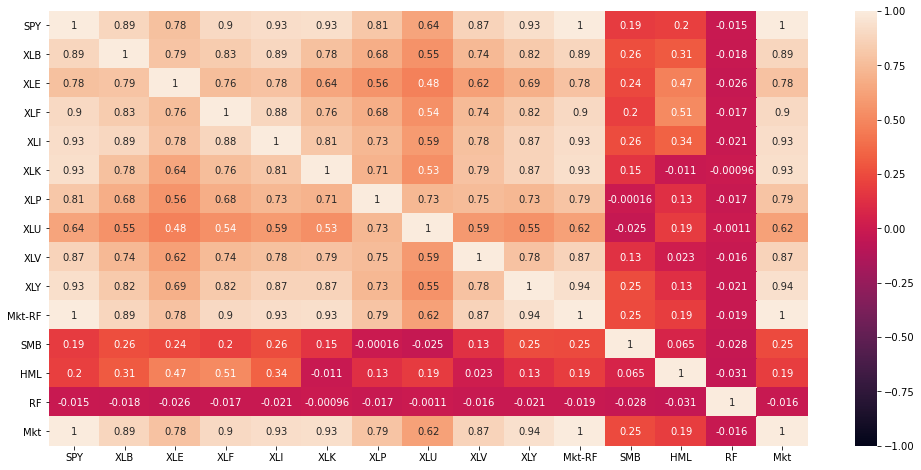

In [8]:
plt.figure(figsize = (10,5))
sns.heatmap(master_df[['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']].corr(), cmap="Blues", annot=True)
plt.show()

plt.figure(figsize = (6,3))
sns.heatmap(master_df[['Mkt-RF','SMB','HML','RF','Mkt']].corr(), cmap="Reds", annot=True)
plt.show()

plt.figure(figsize = (17,8))
sns.heatmap(master_df.corr(), cmap="rocket",vmin = -1, vmax = 1, annot=True)
plt.show()

part C---------------------------------------------------part C---------------------------------------------------part C---------------------------------------------------part C

In [9]:
# rolling corrolations 
def rolling_ninty_day(df):
    spy_rolling_corr = df['SPY'].rolling(90).corr(df['SPY'])
    spy_rolling_corr = spy_rolling_corr.dropna()
    index_rolling = spy_rolling_corr.index
    df_90 = pd.DataFrame(spy_rolling_corr, index_rolling)
    
    for i in range(1, df.shape[1]):
        ETF = df.iloc[: , i]
        etf_rolling_corr = df['SPY'].rolling(90).corr(ETF)
        etf_rolling_corr = etf_rolling_corr.dropna()
        index_rolling = etf_rolling_corr.index
        df_90 = pd.concat([df_90, etf_rolling_corr], axis =1)
    return df_90

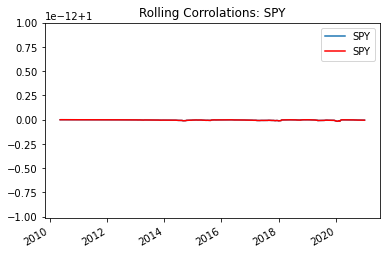

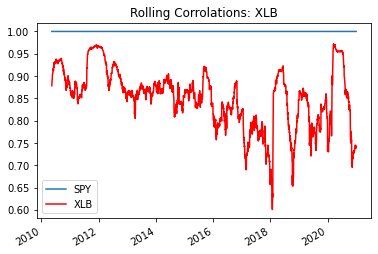

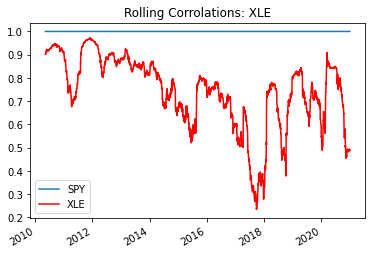

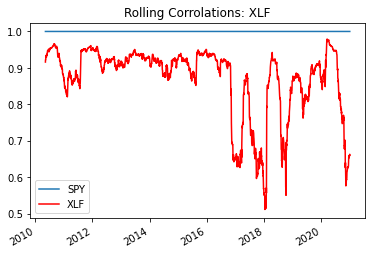

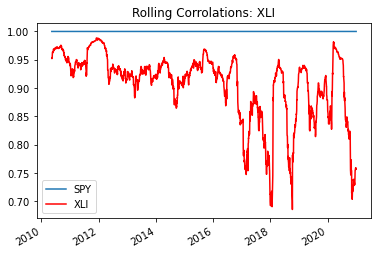

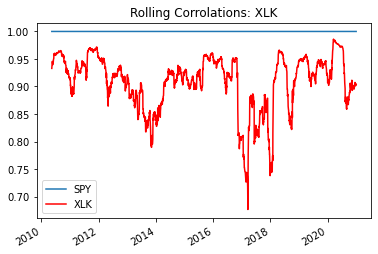

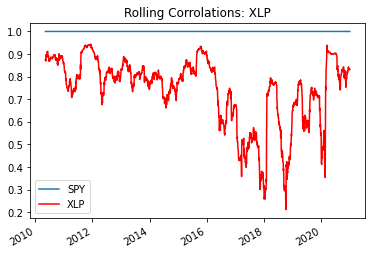

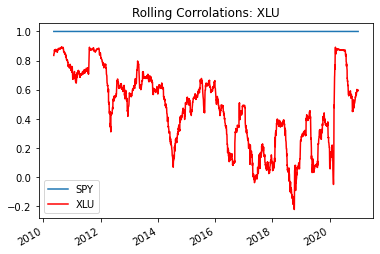

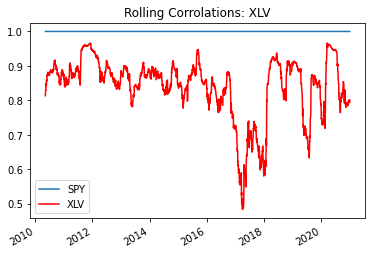

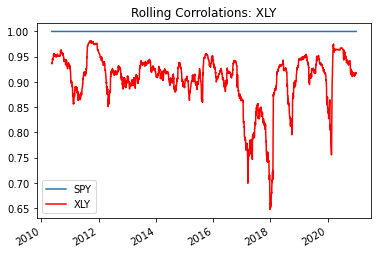

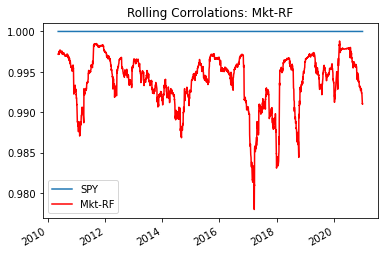

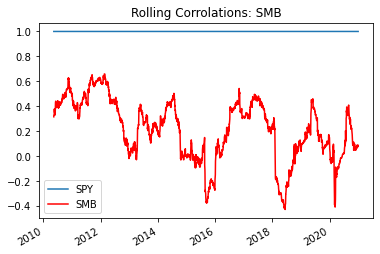

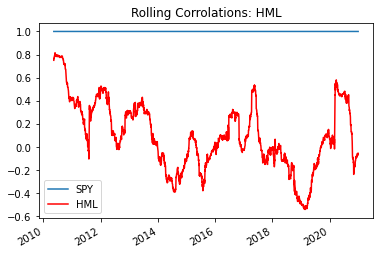

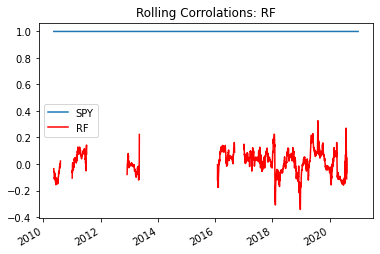

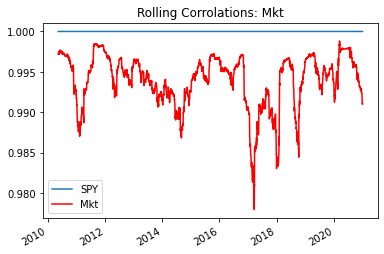

In [10]:
rolling_df = rolling_ninty_day(master_df)

lst_columns = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY','Mkt-RF','SMB','HML','RF','Mkt']
rolling_df.columns = lst_columns
lst_ff = ['Mkt-RF','SMB','HML','RF','Mkt']
for i in range(len(lst_columns)):
    ax = plt.gca()
    plt.title(f'Rolling Corrolations: {lst_columns[i]}')
    rolling_df.plot(kind='line',y='SPY',ax=ax)
    rolling_df.plot(kind='line',y=lst_columns[i],color='red',ax=ax)
    plt.show()


part D---------------------------------------------------part D---------------------------------------------------part D---------------------------------------------------part D

In [11]:
class normality_tests:
    def __init__(self, df):
        self.df = df
    def histogram(self):
        lst_columns = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY','Mkt-RF','SMB','HML','RF','Mkt']
        for i in range(len(lst_columns)):
            sns.displot(self.df[lst_columns[i]], bins=100, kde=True,color="grey")
            plt.xlabel("return values in %")
            plt.ylabel("density of return values")
            plt.title(f"histogram of return values {lst_columns[i]}", size=14)
            plt.show()
        return plt.show()
    
    def probability_density(self):
        lst_columns = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY','Mkt-RF','SMB','HML','RF','Mkt']
        for i in range(len(lst_columns)):
            #print(f'                   Quantile Plot Test for {lst_columns[i]}')
            fig = plt.figure(figsize=(7,5))
            si.probplot(self.df[lst_columns[i]], dist="norm", plot = pylab)
            plt.title(f'Quantile Plot Test :{lst_columns[i]}')
            pylab.show()
        return pylab.show()

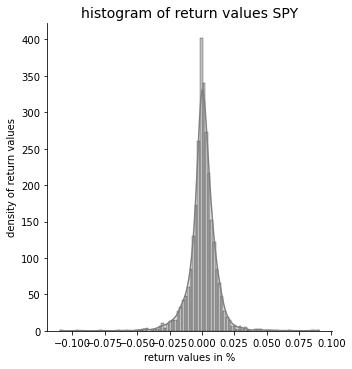

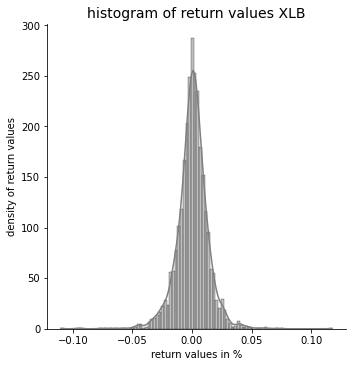

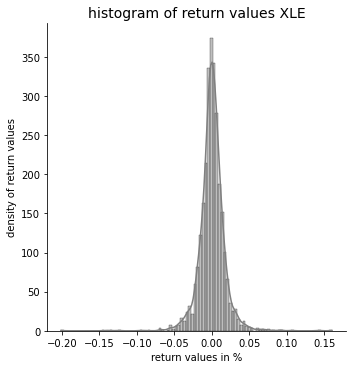

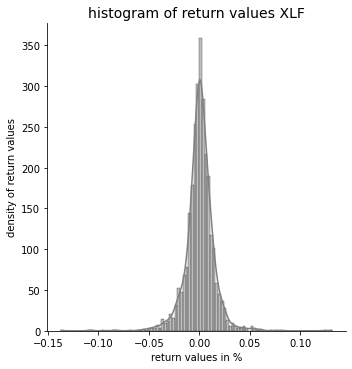

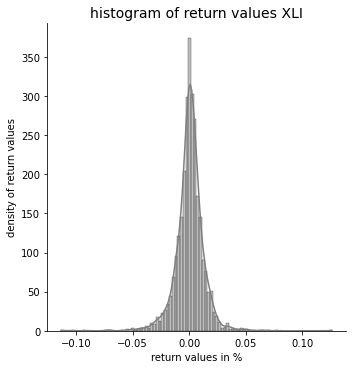

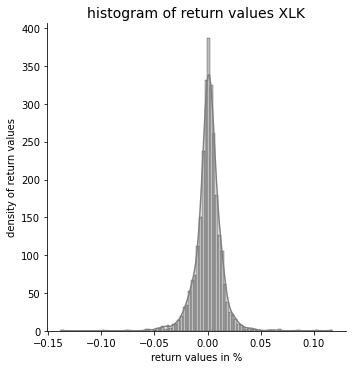

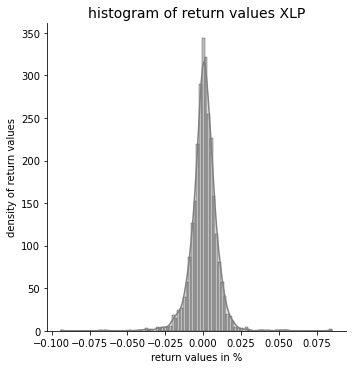

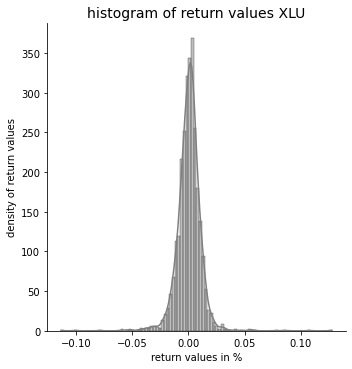

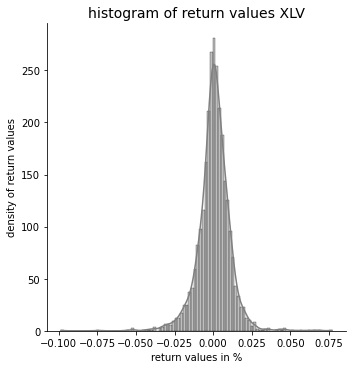

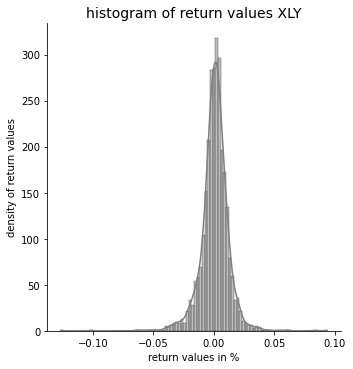

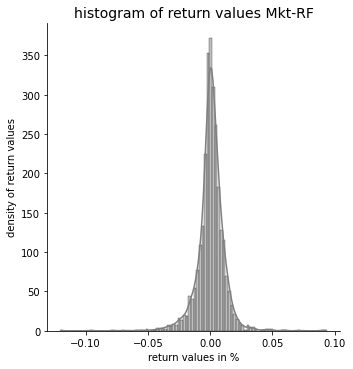

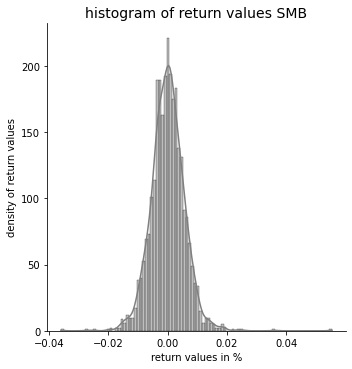

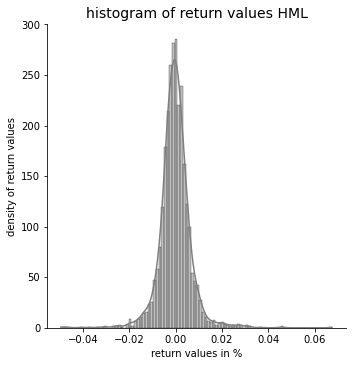

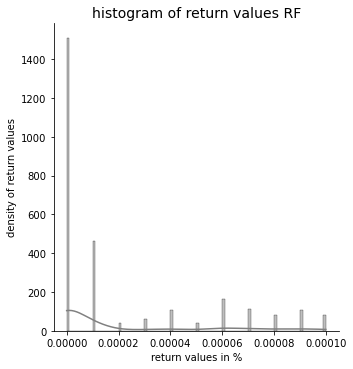

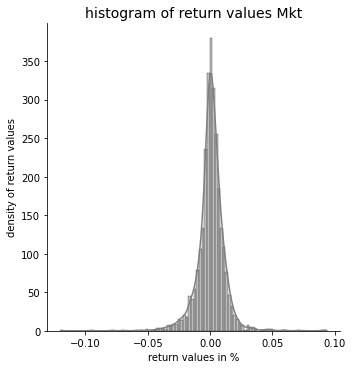

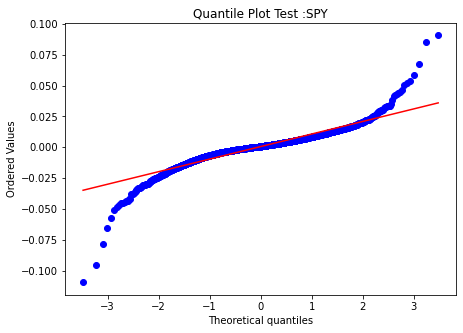

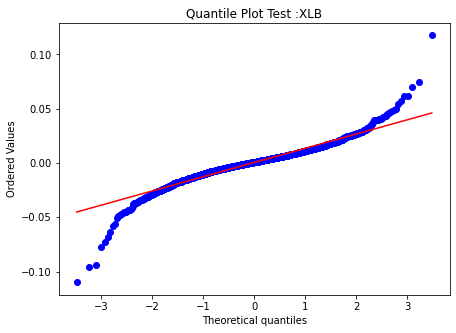

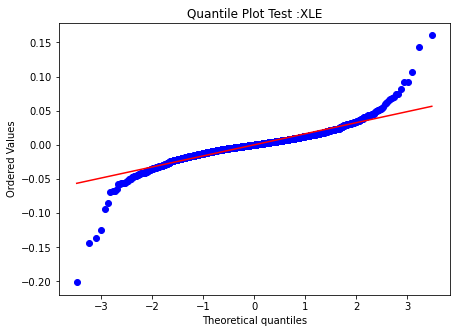

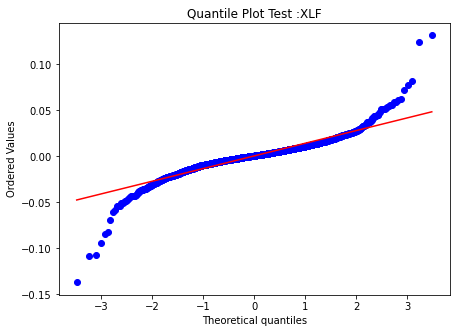

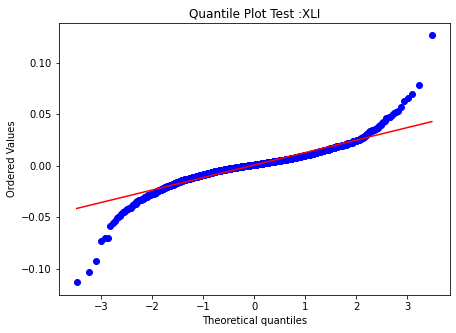

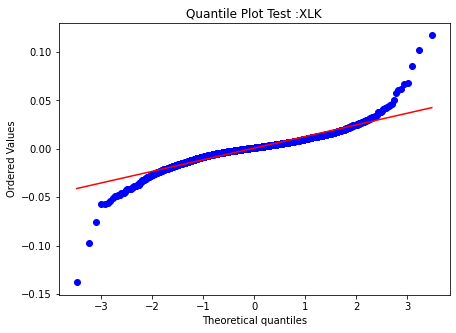

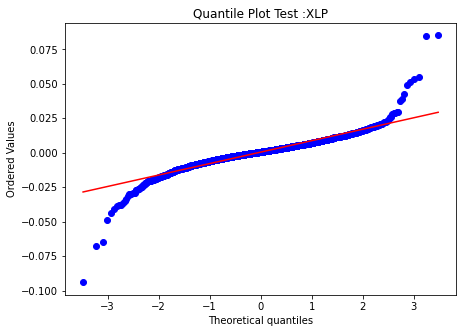

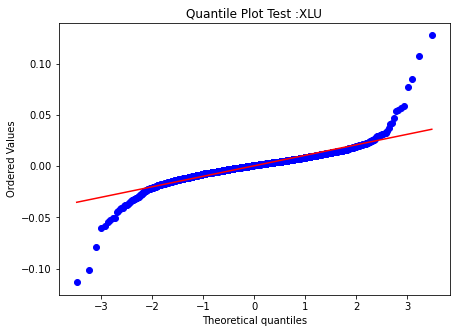

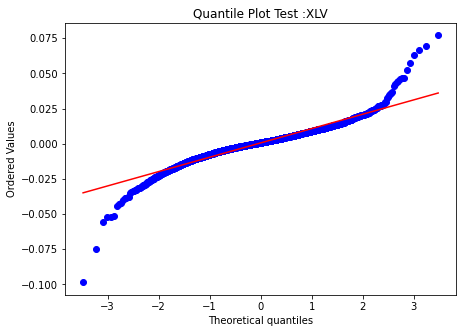

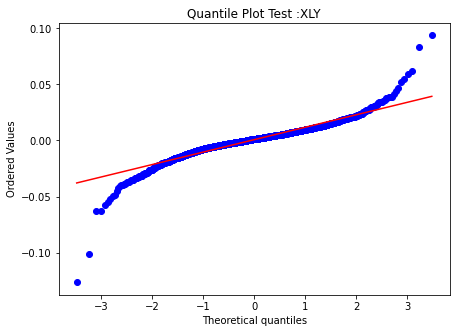

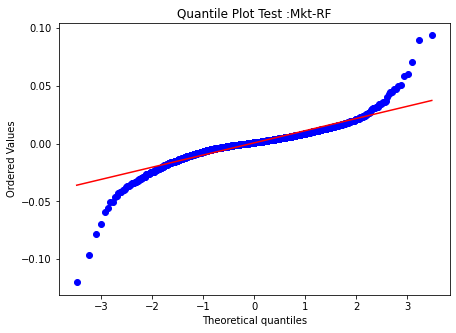

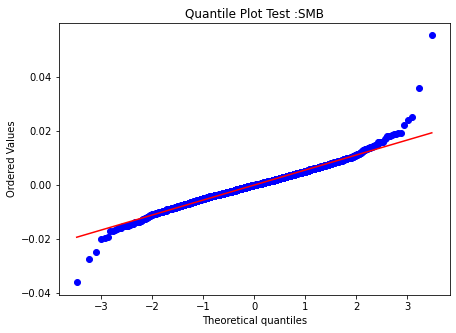

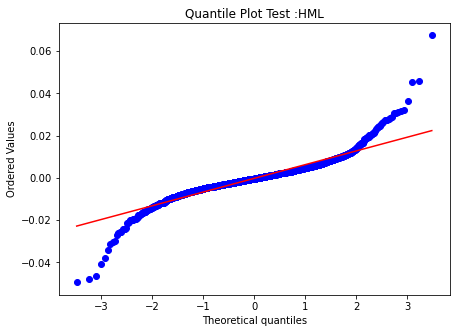

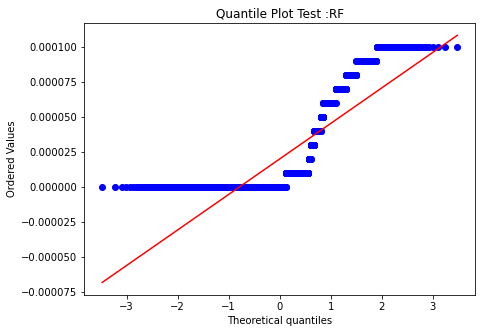

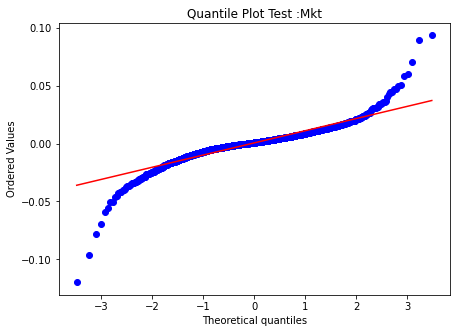

In [12]:
tests = normality_tests(master_df)
tests.histogram()
tests.probability_density()

part E---------------------------------------------------part E---------------------------------------------------part E---------------------------------------------------part E

In [13]:
lst_columns = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
    
def rolling_OLS_regression(df,lst):
    endog = df[lst_columns[i]]
    exog = df[['Mkt-RF','SMB','HML']]
    results = RollingOLS(endog = endog, exog = exog, window=90).fit()
    betas = results.params
    betas = betas.dropna()
    betas.rename(columns={"Mkt-RF": "β(Mkt-RF)", "SMB": "β(SMB)", "HML":"β(HML)"})
    fig = plt.figure(figsize=(14,7))
    plt.plot(betas)
    plt.legend({'β(Mkt-RF)','β(SMB)','β(HML)'}, loc='upper right')
    plt.xlabel('Date')
    plt.ylabel('Beta Values')
    plt.title(f'Rolling Beta: {lst_columns[i]}')

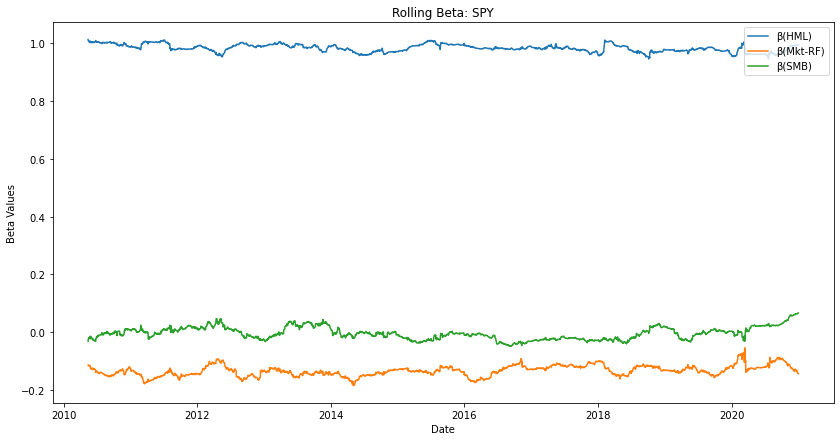

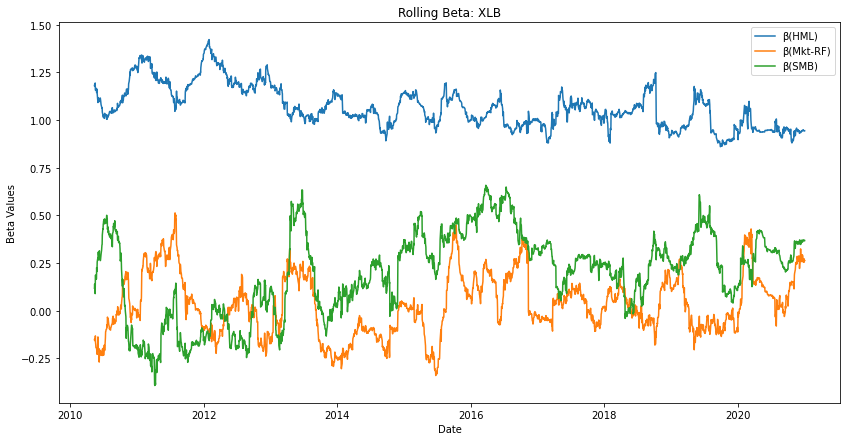

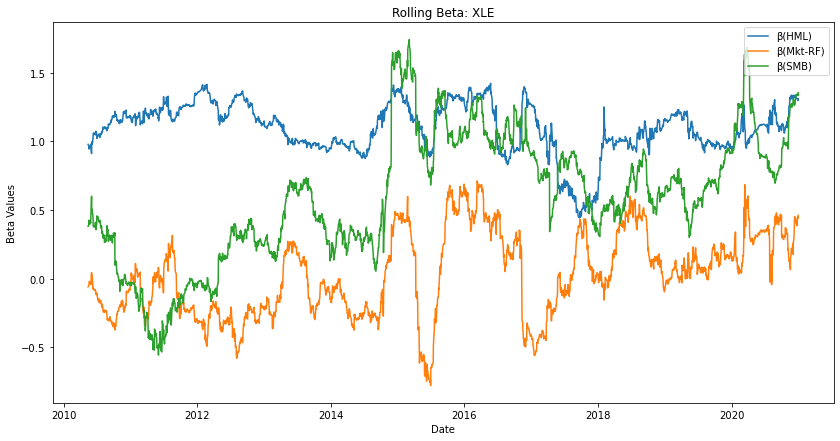

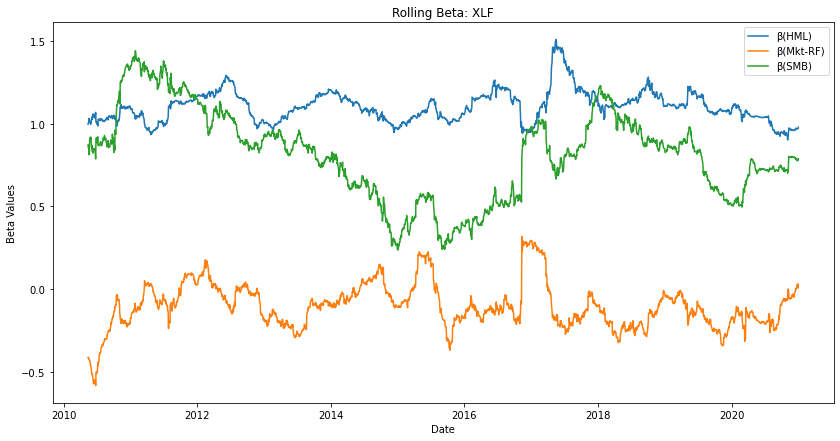

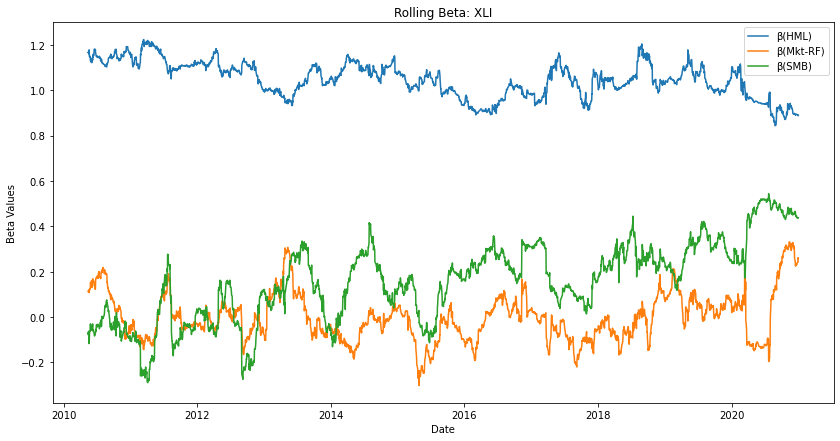

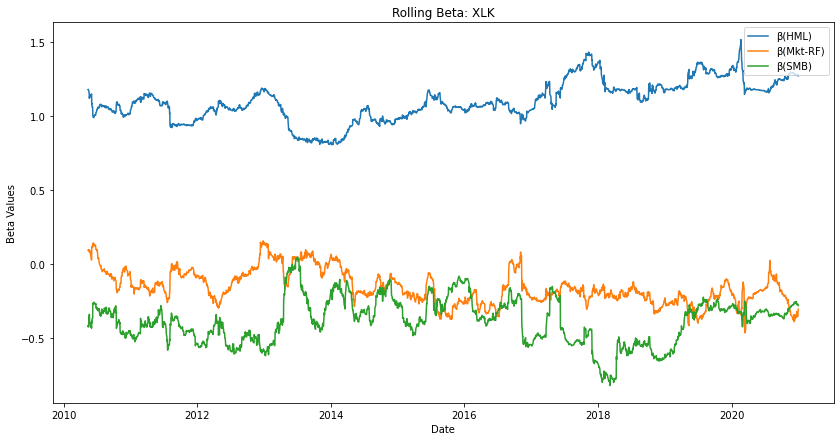

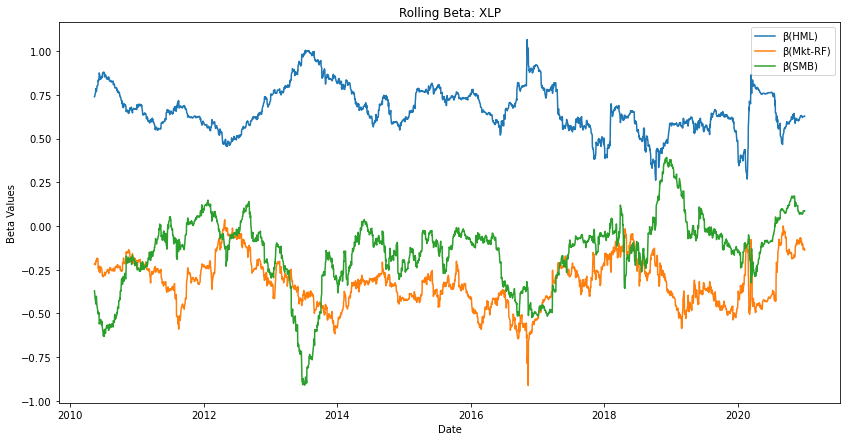

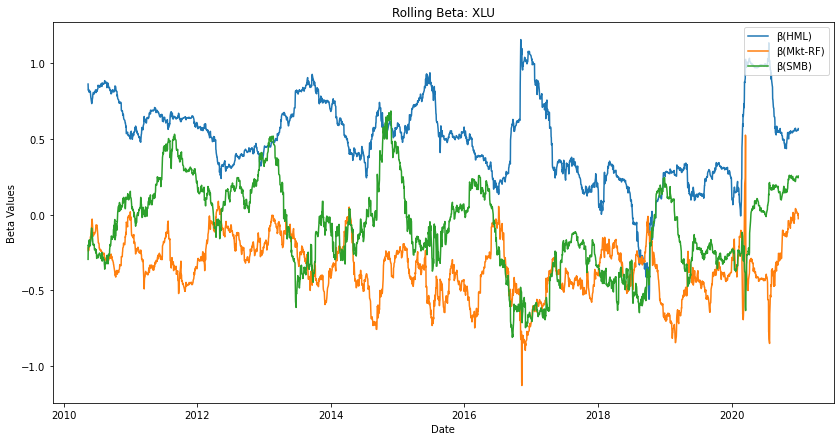

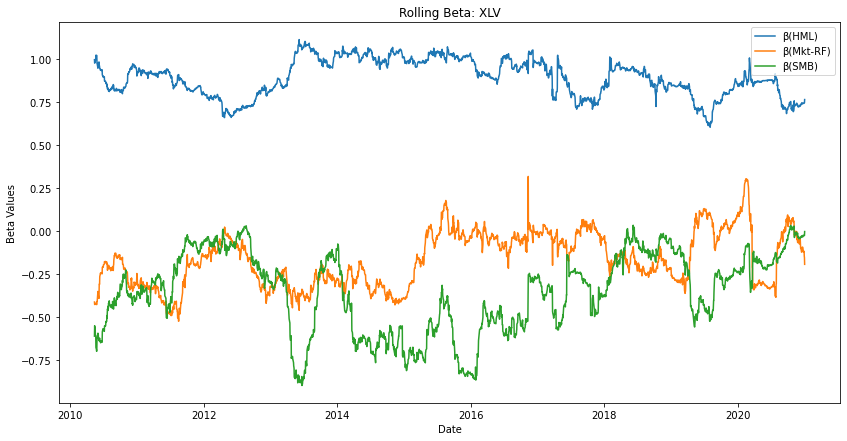

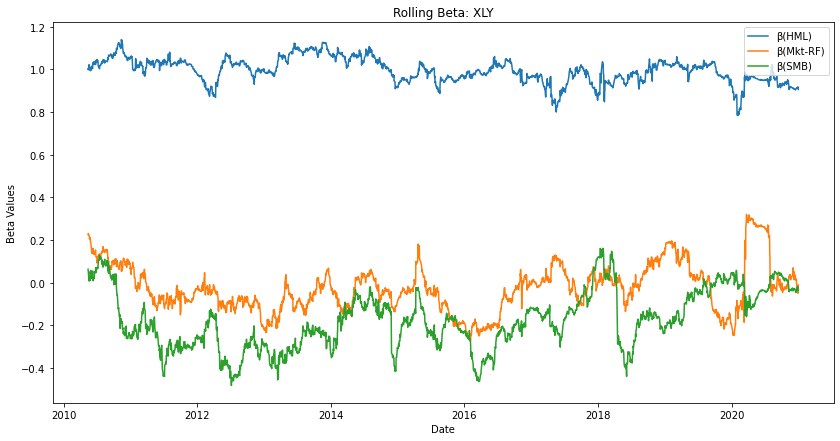

In [14]:
for i in range(len(lst_columns)):
    lst = lst_columns[i]
    rolling_OLS_regression(master_df,lst)

In [15]:
class regression:
    
    lst_columns = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
    def __init__(self,df):
        self.df = df
        
    def OLS_regression(self):
        lst_betas = []
        for i in range(len(lst_columns)):
            y = self.df[lst_columns[i]]
            x = self.df[['Mkt-RF','SMB','HML']]
            results = sm.OLS(y,x).fit()
            lst_betas += [results.params]
        lst_betas = pd.DataFrame(lst_betas, index=lst_columns)
        return lst_betas

In [16]:
reg = regression(master_df)
results = reg.OLS_regression()
print(tabulate(results, headers=['Tickers','Mkt-RF','SMB','HML'], tablefmt='github'))

| Tickers   |   Mkt-RF |        SMB |        HML |
|-----------|----------|------------|------------|
| SPY       | 0.976665 | -0.125971  |  0.0154654 |
| XLB       | 1.03357  |  0.0916061 |  0.278352  |
| XLE       | 1.08862  |  0.125455  |  0.840332  |
| XLF       | 1.09257  | -0.0850767 |  0.751687  |
| XLI       | 1.01402  |  0.0543007 |  0.314783  |
| XLK       | 1.12106  | -0.189206  | -0.360898  |
| XLP       | 0.666558 | -0.329263  | -0.0248257 |
| XLU       | 0.64381  | -0.378282  |  0.117525  |
| XLV       | 0.867685 | -0.161219  | -0.227919  |
| XLY       | 0.980957 |  0.0453316 | -0.0863047 |


part F---------------------------------------------------part F---------------------------------------------------partF---------------------------------------------------part F

In [17]:
class residuals:
    
    lst_columns = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
    def __init__(self,df):
        self.df = df
        
    def resid(self):
        lst_residuals = []
        mean = []
        var = []
        for i in range(len(lst_columns)):
            y = self.df[lst_columns[i]]
            x = self.df[['Mkt-RF','SMB','HML']]
            results = sm.OLS(y,x).fit()
            residuals = results.resid
            lst_residuals += [np.array(residuals)]
            mean += [[np.mean(residuals)]]
            var += [[np.var(residuals)]]
            #print(lst_residuals)
            fig = plt.figure(figsize=(10,5))
            plt.plot(residuals,color="green")
            plt.legend({f'{lst_columns[i]}'}, loc='lower left')
            plt.title(f' The residuals for: {lst_columns[i]}')
        plt.show()
        #print(mean)
        print(tabulate(lst_columns, headers=['tickers'], tablefmt='latex'))
        print(tabulate(mean, headers=['mean'], tablefmt='latex'))
        print(tabulate(var, headers=['variance'], tablefmt='latex'))
        #print(lst_residuals)
        return lst_residuals

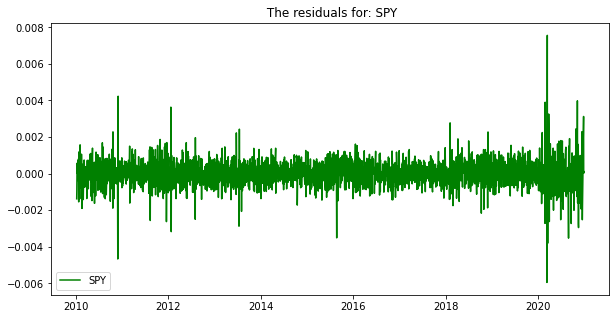

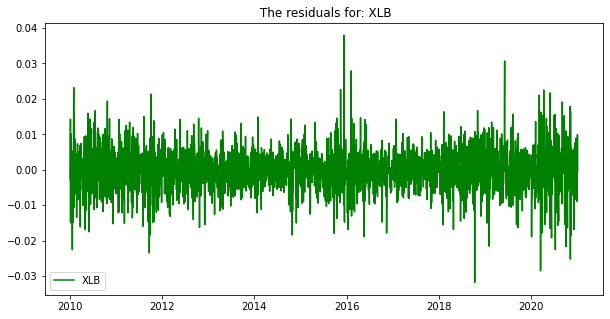

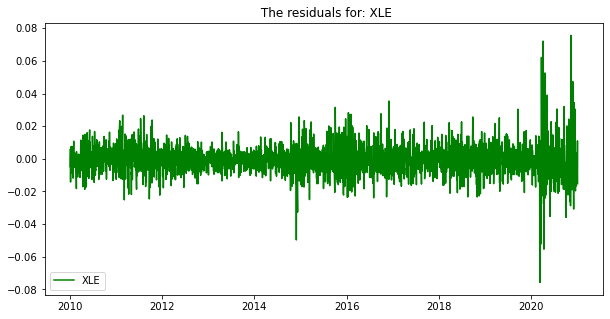

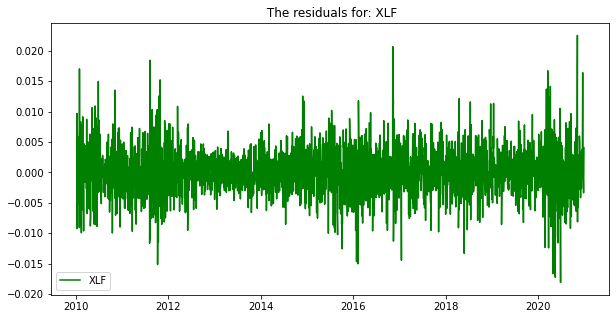

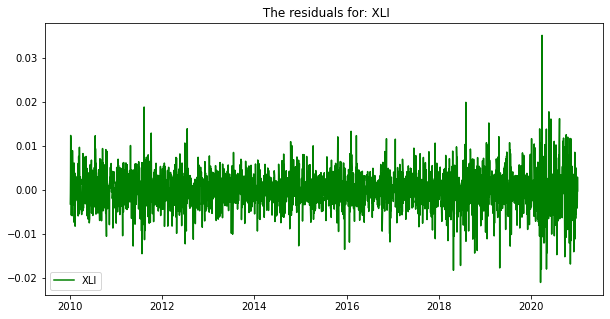

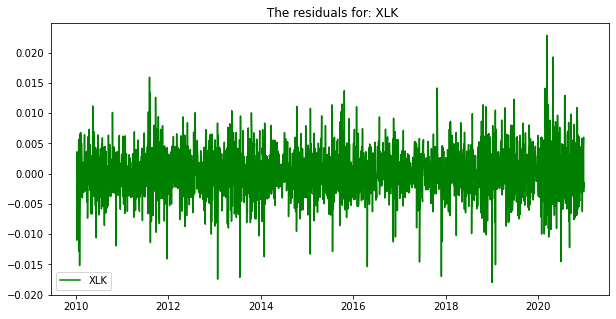

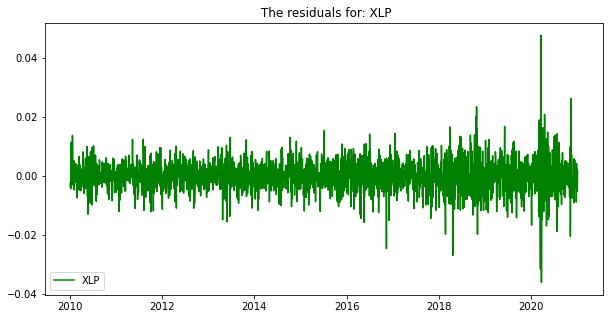

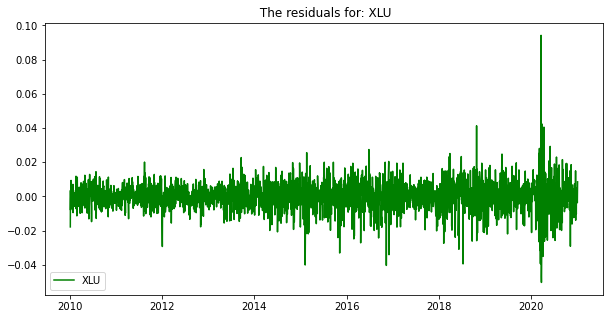

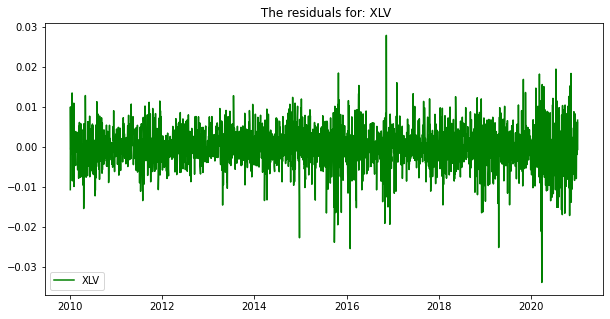

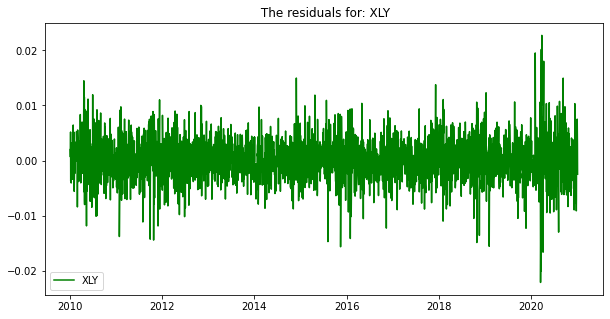

\begin{tabular}{lll}
\hline
    &    & tickers   \\
\hline
 S  & P  & Y         \\
 X  & L  & B         \\
 X  & L  & E         \\
 X  & L  & F         \\
 X  & L  & I         \\
 X  & L  & K         \\
 X  & L  & P         \\
 X  & L  & U         \\
 X  & L  & V         \\
 X  & L  & Y         \\
\hline
\end{tabular}
\begin{tabular}{r}
\hline
         mean \\
\hline
  1.54191e-05 \\
 -8.6658e-05  \\
 -0.000343341 \\
  3.46429e-05 \\
  5.45731e-05 \\
  5.41742e-05 \\
  0.000105289 \\
  0.000126663 \\
  4.7387e-05  \\
  0.00014781  \\
\hline
\end{tabular}
\begin{tabular}{r}
\hline
    variance \\
\hline
 5.15245e-07 \\
 3.45096e-05 \\
 8.43054e-05 \\
 1.51648e-05 \\
 1.80258e-05 \\
 1.49038e-05 \\
 2.57819e-05 \\
 7.10902e-05 \\
 2.47187e-05 \\
 1.55964e-05 \\
\hline
\end{tabular}


In [18]:
resids = residuals(master_df)
results = resids.resid()
#print(tabulate(results, headers=['mean','Variance'], tablefmt='github'))

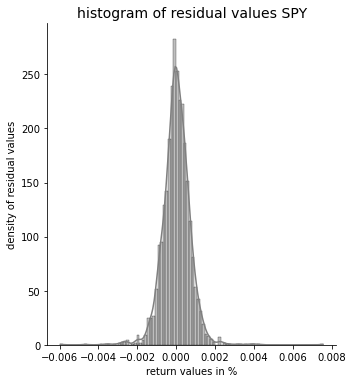

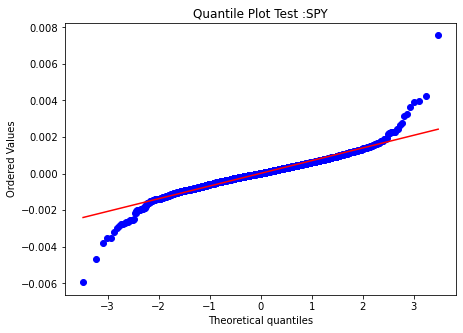

shapiro wilk test forSPY
ShapiroResult(statistic=0.9348198771476746, pvalue=3.3520242624414805e-33)


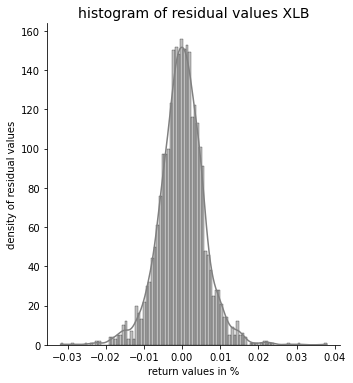

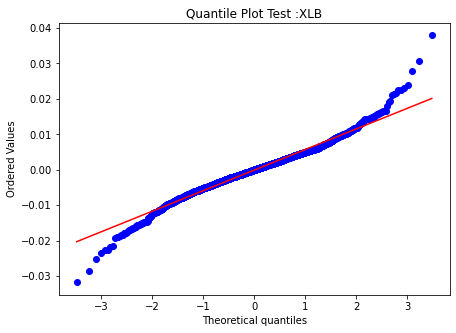

shapiro wilk test forXLB
ShapiroResult(statistic=0.9764529466629028, pvalue=5.433816086830112e-21)


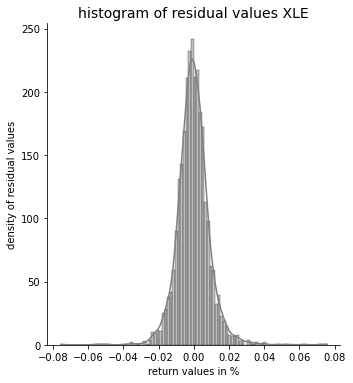

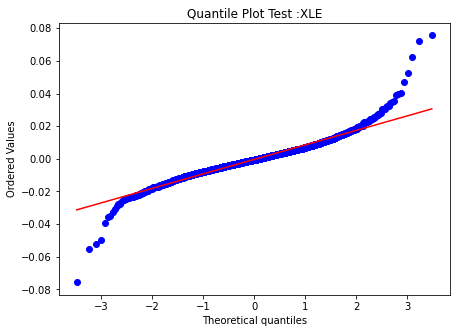

shapiro wilk test forXLE
ShapiroResult(statistic=0.9356663823127747, pvalue=5.021234322132791e-33)


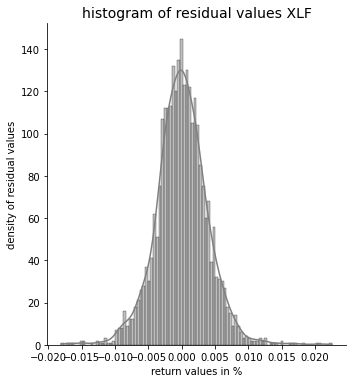

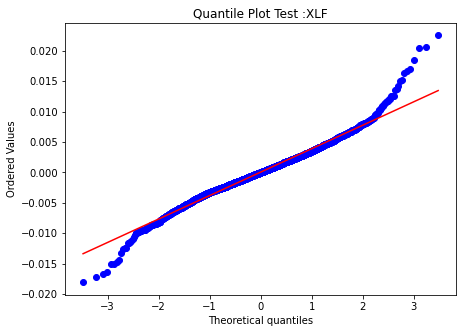

shapiro wilk test forXLF
ShapiroResult(statistic=0.9785706400871277, pvalue=5.198632078913164e-20)


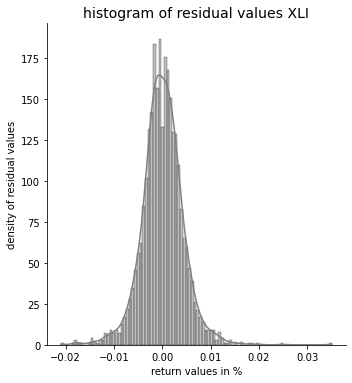

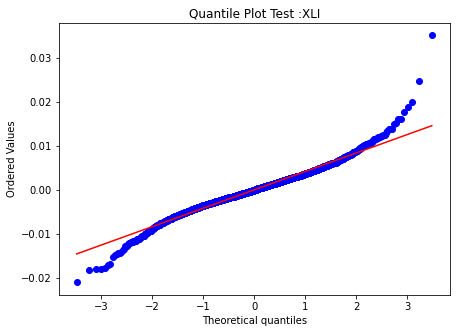

shapiro wilk test forXLI
ShapiroResult(statistic=0.9697967171669006, pvalue=1.0534360964760912e-23)


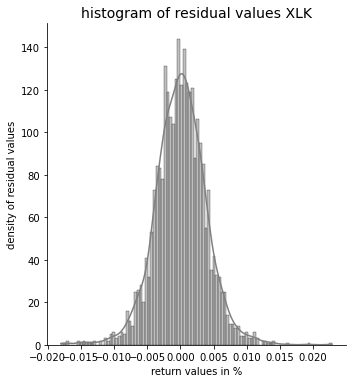

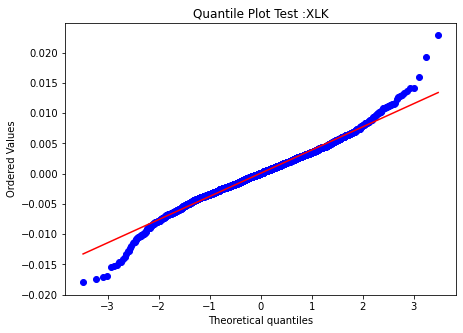

shapiro wilk test forXLK
ShapiroResult(statistic=0.983496367931366, pvalue=2.0051435420352953e-17)


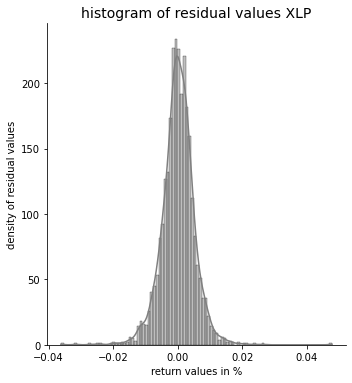

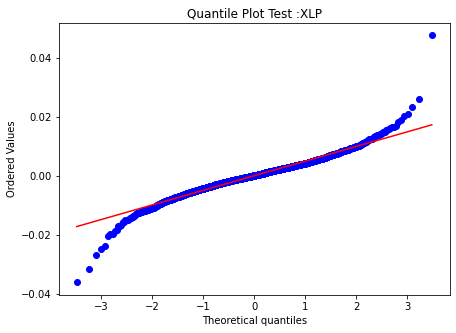

shapiro wilk test forXLP
ShapiroResult(statistic=0.9568527936935425, pvalue=6.741638807199799e-28)


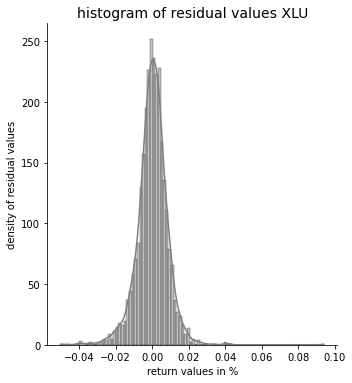

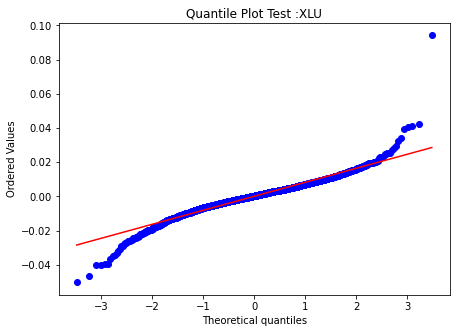

shapiro wilk test forXLU
ShapiroResult(statistic=0.9419121146202087, pvalue=1.1354074073716757e-31)


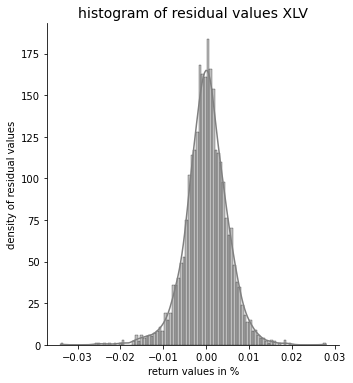

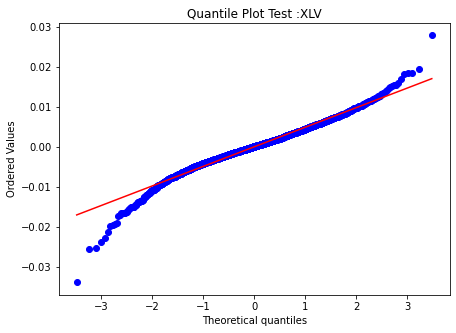

shapiro wilk test forXLV
ShapiroResult(statistic=0.9728951454162598, pvalue=1.6734747568597087e-22)


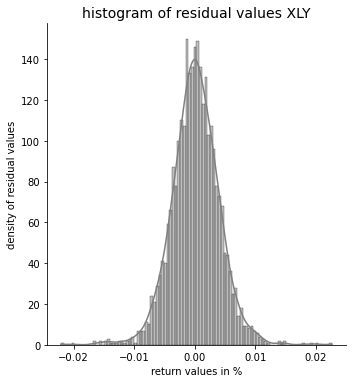

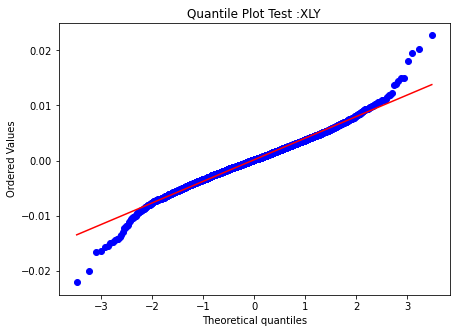

shapiro wilk test forXLY
ShapiroResult(statistic=0.9818084836006165, pvalue=2.2939854580027376e-18)


In [19]:
for i in range(len(lst_columns)):
    sns.displot(results[i], bins=100, kde=True,color="grey")
    plt.xlabel("return values in %")
    plt.ylabel("density of residual values")
    plt.title(f"histogram of residual values {lst_columns[i]}", size=14)
    plt.show()
    #print(f'                   normality test for {lst_columns[i]}')
    fig = plt.figure(figsize=(7,5))
    
    si.probplot(results[i], dist="norm", plot = pylab)
    plt.title(f'Quantile Plot Test :{lst_columns[i]}')
    pylab.show()
    print(f'shapiro wilk test for{lst_columns[i]}')
    s_w = si.shapiro(results[i])
    print(s_w)

Problem (2): Exotic Option Pricing via Simulation-------------------------------------------------------------------------------------------------Exotic Option Pricing via Simulation

In [34]:
# Simulates stock paths based off of a monte carlo simulation process
# Can be set to an object so that it can be put into other processes
class monte_carlo_simulation:
    def __init__(self, S0, t, r, sigma, n):
        # S0 = stock price 
        # t = time to maturity as fraction of a year
        # r = interest rate
        # sigma = volatility
        # n = number of time periods
        # m = number of simulations
        self.S0 = S0
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n = n
        
    def generate_simulated_stock_returns(self):
        # simulates the stock return values of a stock
        # goes directly to: generate_simulated_stock_values(self):
        mu = self.r
        returns = []
        numsteps = int(self.t * self.n//1)
        for i in range(numsteps):
            z = np.random.normal()
            #stock_return = (mu - (self.sigma ** 2) / 2) * (1 / self.n) + z * self.sigma * ((1 / self.n) ** 0.5)
            stock_return = z * self.sigma * ((1 / self.n) ** 0.5)
            returns.append(stock_return)
        return np.array(returns)
    
    def generate_simulated_stock_values(self):
        # generates stock paths that can be used to value path dependant options
        stock_path = [self.S0]
        returns = self.generate_simulated_stock_returns()
        numsteps = int(self.t * self.n//1)
        for i in range(numsteps):
            #snext = stock_path[i] * np.exp(returns[i])
            snext = stock_path[i] + returns[i]
            stock_path.append(snext)
        return np.array(stock_path)
    
    def plot_simulated_stock_values(self, num_trials = 1):
        # plots the simulation as a check to see if the paths look reasonable
        number_x = int(self.t * self.n//1)
        term_x = 1 / self.n
        x = 0
        list_for_x = [0]
        for i in range(number_x):
            x += term_x 
            list_for_x.append(x)
        for j in range(num_trials):
            list_y = self.generate_simulated_stock_values()
            plt.plot(list_for_x, list_y) 
        plt.title(f'{num_trials} simulated trials')
        plt.xlabel('years')
        plt.ylabel('$ value')
        return plt.show()

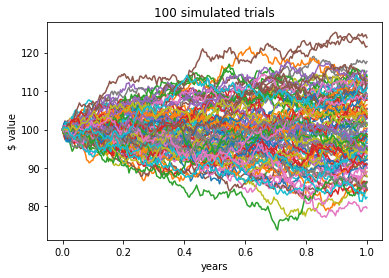

In [35]:
sim = monte_carlo_simulation(100, 1, 0, 10.0, 252)
sim.plot_simulated_stock_values(100)

In [36]:
class stock_terminal_values:
    def __init__(self, S0, t, r, sigma, n):
        self.S0 = S0
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n = n
        
    def terminal_value(self, num_trials = 1):
        lst_s0 = []
        simulation = monte_carlo_simulation(self.S0, self.t, self.r, self.sigma, self.n)
        for j in range(num_trials):
            path = simulation.generate_simulated_stock_values()
            lst_path = path
            lst_path_term = lst_path[-1]
            lst_s0.append(lst_path_term)
        
        return lst_s0
    
    def terminal_delta_value(self, num_trials = 1):
        lst_s0 = []
        simulation = monte_carlo_simulation(self.S0, self.t, self.r, self.sigma, self.n)
        for j in range(num_trials):
            path = simulation.generate_simulated_stock_values()
            lst_path = path
            lst_path_term = lst_path[-3]
            lst_s0_delta.append(lst_path_term)
        
        return lst_s0_delta

In [37]:
stock_terminals = stock_terminal_values(100, 1, 0, 10.0, 252)
terminals = stock_terminals.terminal_value(1000)

part B---------------------------------------------------part B---------------------------------------------------part B---------------------------------------------------part B

In [24]:
class normality_tests:
    def __init__(self, lst_paths):
        self.terminals = lst_paths
    def histogram(self, terminals):
        sns.displot(terminals, bins=100, kde=True,color="grey")
        plt.xlabel("terminal values")
        plt.ylabel("density of terminal values")
        plt.title("histogram of terminal values", size=14)
        
        return plt.show()
    
    def probability_density(self):
        si.probplot(terminals, dist="norm", plot = pylab)
        return pylab.show()
    
    def prob_plot_2(self):
        plt.title("density", size=14)
        return sns.histplot(data = terminals,log_scale=True, element="step", fill=False,cumulative=True, stat="density", common_norm=False,)

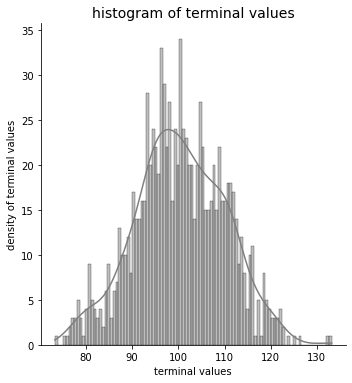

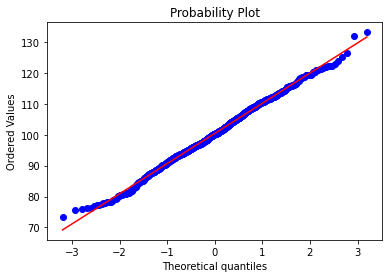

<AxesSubplot:title={'center':'density'}, ylabel='Density'>

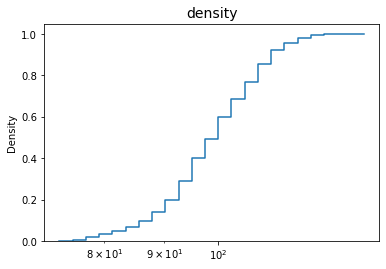

In [25]:
tests = normality_tests(terminals)
tests.histogram(terminals)
tests.probability_density()
tests.prob_plot_2()

part C---------------------------------------------------part C---------------------------------------------------part C---------------------------------------------------part C

In [26]:
class MCStockOption(monte_carlo_simulation):

    def __init__(self, S0, K, t, r, sigma, n, num_trials):
        # S0 = stock price 
        # K = strike price
        # t = time to maturity as fraction of a year
        # r = interest rate
        # sigma = volatility
        # n = number of time periods
        # num_trials = number of simulations
        self.S0 = S0
        self.K = K
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n
        self.num_trials = num_trials
        
    def __repr__(self):
        # prints a nicely formated object
        return f'MCStockOption (s=${self.S0:8.2f}, K={self.K:8.2f}, t={self.t:8.2f} (years), r={self.r:8.2f}, sigma={self.sigma:8.2f}, number of periods={self.n:8.2f}, num_trials={self.num_trials:8.2f}'

    def value(self):
        #will not actually perform anything, will get called in following classes
        if 'value' in dir(self):
            return self.value
        else:
            return 0
        
    def stderr(self):
        # computes a standard error
        if 'stdev' in dir(self):
            return self.stdev / math.sqrt(self.num_trials)
        return 0

In [39]:
class MC_Lookback_Put(MCStockOption):
    # class for a lookback put option
    def __init__(self, S0, K, t, r, sigma, n, num_trials):
        # S0 = stock price 
        # K = strike price
        # t = time to maturity as fraction of a year
        # r = interest rate
        # sigma = volatility
        # n = number of time periods
        # num_trials = number of simulations
        self.S0 = S0
        self.K = K
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n = n
        self.num_trials = num_trials
        # s = initial 
        super().__init__(S0, K, t, r, sigma, n, num_trials)
        
    def __repr__(self):
        # prints a nicely formated object
        return f'MCLookbackPutOption, S0={self.S0}, K={self.K}, t={self.t}, r={self.r}, sigma={self.sigma}, number of periods={self.n}, num_trials={self.num_trials}'

    def value(self):
        
        lst_sx_lookbackput = []
        for j in range(self.num_trials):
            sx_call = self.generate_simulated_stock_values()
            sp_call = sx_call
            sp_min = min(sp_call)
            call_value = max(self.K - sp_min, 0) * np.exp(-self.r * self.t)
            lst_sx_lookbackput.append(call_value)
            
        self.mean = np.mean(lst_sx_lookbackput)
        self.stdev = np.var(lst_sx_lookbackput)
        
        return self.mean

In [40]:
lookback_put = MC_Lookback_Put(100, 100, 1, 0, 10.0, 252, 1000)
print(lookback_put)
lookback_put_value = lookback_put.value()
print(lookback_put.value())
#print(lookback_put.stderr())

MCLookbackPutOption, S0=100, K=100, t=1, r=0, sigma=10.0, number of periods=252, num_trials=1000
7.8768143698401145


In [29]:
class MC_euro_put(MCStockOption):

    def __init__(self, S0, K, t, r, sigma, n, num_trials):
        # S0 = stock price 
        # K = strike price
        # t = time to maturity as fraction of a year
        # r = interest rate
        # sigma = volatility
        # n = number of time periods
        # num_trials = number of simulations
        self.S0 = S0
        self.K = K
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n = n
        self.num_trials = num_trials
        # s = initial 
        super().__init__(S0, K, t, r, sigma, n, num_trials)
        
    def __repr__(self):
        # prints a nicely formated object
        return f'MC, MC_euro_put S0={self.S0}, K={self.K}, t={self.t}, r={self.r}, sigma={self.sigma}, number of periods={self.n}, num_trials={self.num_trials}'

    def value(self):
        
        lst_sx_put = []
        for i in range(self.num_trials):
            sx_put = self.generate_simulated_stock_values()
            sp_put = sx_put[-1]
            put_value = max(self.K - sp_put, 0) * np.exp(-self.r * self.t)
            lst_sx_put.append(put_value)
            
        self.mean = np.mean(lst_sx_put)
        self.stdev = np.std(lst_sx_put)
        
        return self.mean

In [30]:
euro_put = MC_euro_put(100, 100, 1, 0, 10.0, 252, 1000)
pure_euro = euro_put.value()
print(f'Euro put value: {pure_euro}')

Euro put value: 4.217461894835533


In [31]:
print(f'The difference between the lookback option and the european option values is: {lookback_put_value-pure_euro}')

The difference between the lookback option and the european option values is: 3.702162748632343


part D--------------------------------------------------------part D--------------------------------------------------------part D--------------------------------------------------------part D

In [32]:
class finite_difference_delta:

    def __init__(self, S0, K, t, r, sigma, n, num_trials, epsilon):
        # S0 = stock price 
        # K = strike price
        # t = time to maturity as fraction of a year
        # r = interest rate
        # sigma = volatility
        # n = number of time periods
        # num_trials = number of simulations
        # epsilon = error
        self.S0 = S0
        self.K = K
        self.t = t
        self.r = r
        self.sigma = sigma
        self.n = n
        self.num_trials = num_trials
        self.epsilon = epsilon
        #super().__init__(S0, K, t, r, sigma, n, num_trials, epsilon)
        
    def __repr__(self):
        # prints a nicely formated object
        return f' finite_difference_delta  S0={self.S0}, K={self.K}, t={self.t}, r={self.r}, sigma={self.sigma}, number of periods={self.n}, num_trials={self.num_trials} epsioln={epsilon}'

    def delta(self):
        
        c1 = MC_Lookback_Put(self.S0+self.epsilon, self.K, self.t, self.r, self.sigma, self.n,self. num_trials)
        c2 = MC_Lookback_Put(self.S0-self.epsilon, self.K, self.t, self.r, self.sigma, self.n,self. num_trials)
        
        p1 = c1.value()
        p2 = c1.value()
        put_delta =  (p1 - p2)/(2 * self.epsilon)
        return put_delta

In [33]:
lst = [0.95,0.90,0.85,0.8,0.75,0.7,0.65,0.6,0.55,0.5,0.45,0.4,0.35,0.3,0.25,0.2,0.15,0.1,0.05]
lst1 = [1.2,1.1,1.075,1.05,1.025,1,0.975,0.95,0.925,0.9,0.8]
lst_epsilons=[]
for i in range(len(lst)):
    delta_sim = finite_difference_delta(100, 100, 1, 0, 10.0, 252, 1000, lst[i])
    print(f'{lst[i]}   and delta: {delta_sim.delta()}')
    lst_e = delta_sim.delta()
    lst_epsilons += [lst_e]
print(np.mean(lst_epsilons))

0.95   and delta: -0.26909747951925883
0.9   and delta: 0.23486789911306605
0.85   and delta: -0.12613235153526128
0.8   and delta: -0.0963703217268791
0.75   and delta: 0.05494448081245137
0.7   and delta: 0.09220303285899703
0.65   and delta: 0.1564898596373425
0.6   and delta: 0.067446704268835
0.55   and delta: -0.2069424224926591
0.5   and delta: -0.14490584318536648
0.45   and delta: 0.28014768766964615
0.4   and delta: -0.04978750866497905
0.35   and delta: -0.34754818991433545
0.3   and delta: -0.5310968738958133
0.25   and delta: -1.0027059470456265
0.2   and delta: 0.22877220525572062
0.15   and delta: -0.6676294994787184
0.1   and delta: 0.7293519268115345
0.05   and delta: -3.372963647759102
-0.06876766983330902


In [99]:
print(len(lst))
print(len(lst_epsilons))
neg = []
for j in range(len(lst)):
    print(f'epsilon = {lst[j]} and delta: {lst_epsilons[j]*np.exp(0)}')
    neg += [1 - lst_epsilons[j]]

19
19
epsilon = 0.95 and delta: -0.08990486611787048
epsilon = 0.9 and delta: 0.061659865625486435
epsilon = 0.85 and delta: 0.0892900883490476
epsilon = 0.8 and delta: -0.01532712793404889
epsilon = 0.75 and delta: 0.33799625752999063
epsilon = 0.7 and delta: 0.2493878232240527
epsilon = 0.65 and delta: -0.1438764382593808
epsilon = 0.6 and delta: 0.4365805597571012
epsilon = 0.55 and delta: -0.06684265627566158
epsilon = 0.5 and delta: 0.32315441966726954
epsilon = 0.45 and delta: -0.09655331883688056
epsilon = 0.4 and delta: -0.2232648787197089
epsilon = 0.35 and delta: -0.024871513453137747
epsilon = 0.3 and delta: 0.1054692472924194
epsilon = 0.25 and delta: 0.4142646575951794
epsilon = 0.2 and delta: -0.19314004502422044
epsilon = 0.15 and delta: 0.5256553876488143
epsilon = 0.1 and delta: 0.9342655698801172
epsilon = 0.05 and delta: 3.045966616921705


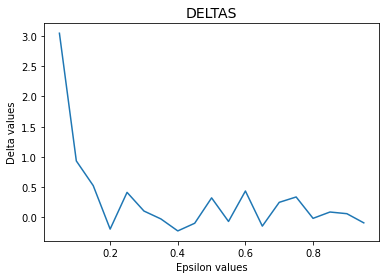

In [100]:
plt.xlabel("Epsilon values")
plt.ylabel("Delta values")
plt.title("DELTAS", size=14)
plt.plot(lst,lst_epsilons)

calculation checks and tests------------------------------------------------calculation checks and tests------------------------------------------------calculation checks and tests

In [57]:
def delta_put(S, K, T, r, sigma):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    delta_put = si.norm.cdf(-d1, 0.0, 1.0)
    
    return -delta_put

def delta(S, K, T, r, sigma, option = 'call'):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = si.norm.cdf(d1, 0.0, 1.0)
    if option == 'put':
        result = -si.norm.cdf(-d1, 0.0, 1.0)
        
    return result

In [58]:
delta(100, 100, 1, 0.0,0.10, option = 'put')

-0.4800611941616275

In [59]:
def euro_put(s_0, K, T, r, sigma):
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(s_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(s_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    put = (K * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - s_0 * si.norm.cdf(-d1, 0.0, 1.0))
    
    return put

In [60]:
BS_put = euro_put(100, 100, 1, 0.0, 0.1)
print(BS_put)

3.987761167674492


In [59]:
def lookbackput_fixed(So,K,T,r,sigma,M,N):
    
    S = sp.random.rand(N+1)
    sumpayoff = 0.0
    premium = 0.0
    dt = T/N
    
    # STEP 2: MAIN SIMULATION LOOP
    for j in range(M):
   	
        S[0]=So

        # STEP 3: TIME INTEGRATION LOOP
        for i in range(N):
        
            epsilon =  sp.random.randn(1)
            S[i+1] = S[i]*(1+r*dt+sigma*math.sqrt(dt)*epsilon)
        
        # STEP 4: COMPUTE PAYOFF
        Smin = min(S)
        sumpayoff += max(0, K-Smin)*np.exp(-r*T)
        
    # STEP 5: COMPUTE DISCOUNTED EXPECTED PAYOFF
    premium =  math.exp(-r*T)*(sumpayoff / M) 
    
    
    return premium

In [60]:
print(lookbackput_fixed(100, 100, 1, 0, 0.1,10000,252))

7.39367665119165
